In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, ConfusionMatrixDisplay

In [3]:
sns.set(rc = {'figure.figsize':(20,15)})

In [4]:
df = pd.read_csv('../../datasets/classification/train.csv')

In [5]:
def pre(df):
  df = df.drop('Unnamed: 0', axis=1)
  df = df.drop('id', axis=1)
  df.columns = [c.replace(' ', '_') for c in df.columns]
  df['Arrival_Delay_in_Minutes'] = df['Arrival_Delay_in_Minutes'].fillna(df['Arrival_Delay_in_Minutes'].mean())
  df['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
  df['Gender'].replace({'Male': 0, 'Female': 1},inplace = True)
  df['Customer_Type'].replace({'disloyal Customer': 0, 'Loyal Customer': 1},inplace = True)
  df['Type_of_Travel'].replace({'Personal Travel': 0, 'Business travel': 1},inplace = True)
  df['Class'].replace({'Eco': 0, 'Eco Plus': 1, 'Business': 2},inplace = True)
  df[['Age', 'Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']].describe()
  return df

### Feature Engineering

In [6]:
def fe(df):
  df['Delay'] = df[['Arrival_Delay_in_Minutes', 'Departure_Delay_in_Minutes']].mean(axis=1)
  df = df.drop('Arrival_Delay_in_Minutes', axis=1)
  df = df.drop('Departure_Delay_in_Minutes', axis=1)
  df['Extra_Amenities'] = df[['Food_and_drink', 'Seat_comfort', 'Inflight_entertainment', 'Cleanliness']].mean(axis=1)
  df = df.drop('Food_and_drink', axis=1)
  df = df.drop('Seat_comfort', axis=1)
  df = df.drop('Inflight_entertainment', axis=1)
  df = df.drop('Cleanliness', axis=1)
  df['Extra_Tech'] = df[['Ease_of_Online_booking', 'Inflight_wifi_service']].mean(axis=1)
  df = df.drop('Ease_of_Online_booking', axis=1)
  df = df.drop('Inflight_wifi_service', axis=1)
  df['Crew_Service'] = df[['Inflight_service', 'On-board_service', 'Baggage_handling']].mean(axis=1)
  df = df.drop('Inflight_service', axis=1)
  df = df.drop('On-board_service', axis=1)
  df = df.drop('Baggage_handling', axis=1)
  return df

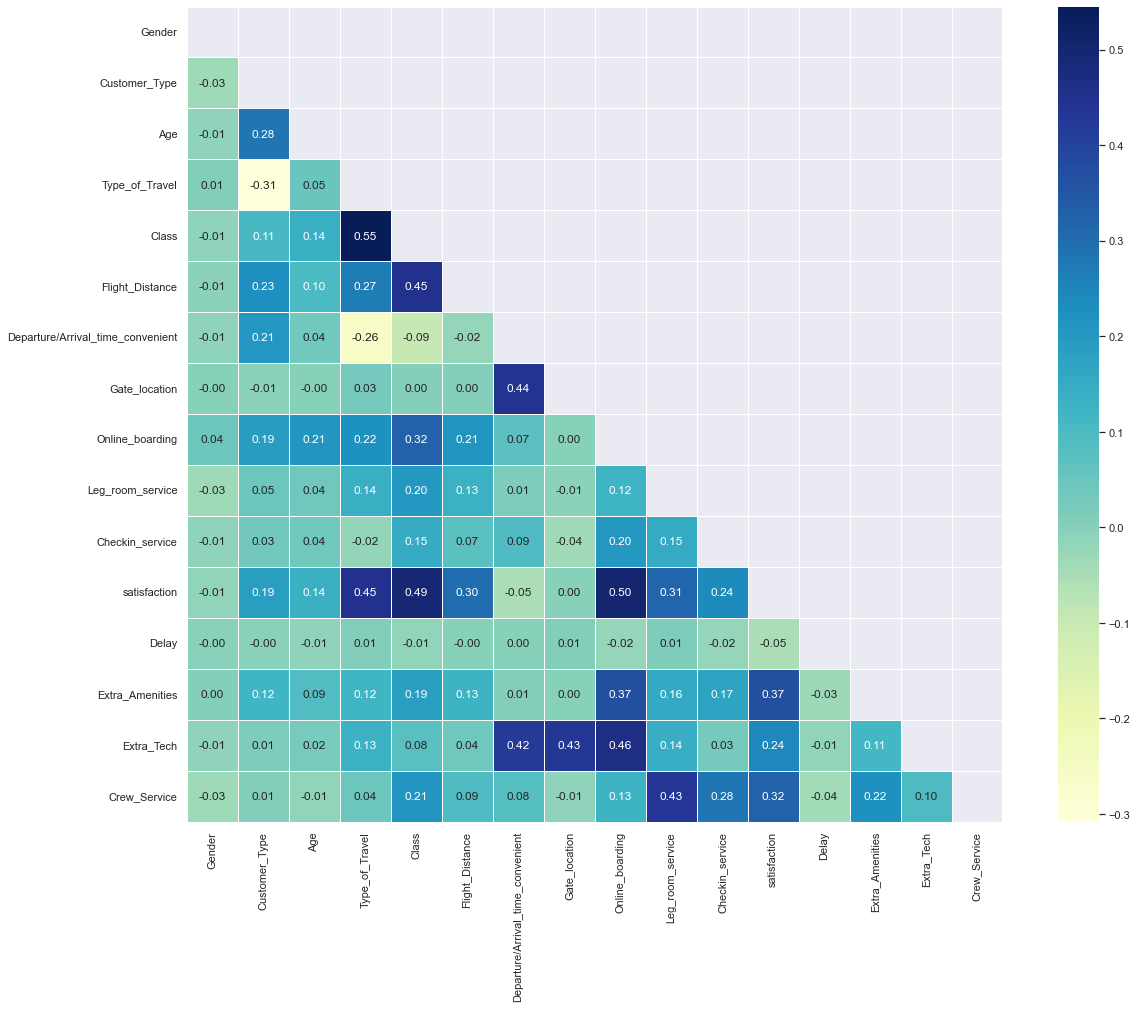

In [7]:
df = pre(df)
df = fe(df)
corr = df.corr()
mask = np.triu(np.ones_like(df.corr()))
sns.set(rc = {'figure.figsize':(20,15)})
g = sns.heatmap(corr, mask=mask, cmap="YlGnBu", square=True, annot=True, linewidths=0.5, fmt='.2f')

In [8]:
X = df[['Gender', 'Customer_Type', 'Age', 'Type_of_Travel', 'Class',
       'Flight_Distance', 'Departure/Arrival_time_convenient', 'Gate_location',
       'Online_boarding', 'Leg_room_service', 'Checkin_service',
       'Delay', 'Extra_Amenities', 'Extra_Tech', 'Crew_Service']]
Y = df['satisfaction']
num_folds = 10
seed = 7
scoring = 'accuracy'
names = []

In [11]:
res_p = []
models = []
models.append(('LR', LogisticRegression(max_iter = 10000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier(eval_metric = 'logloss')))
models.append(('RFC', RandomForestClassifier()))
models.append(('CAT', CatBoostClassifier(verbose=0)))

for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    res_p.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.871275 (0.003238)
LDA: 0.867628 (0.003355)
KNN: 0.753927 (0.004682)
CART: 0.926596 (0.002196)
NB: 0.856762 (0.003898)
XGB: 0.949559 (0.002133)
RFC: 0.948443 (0.002192)
CAT: 0.951494 (0.001944)


In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_p)
ax.set_xticklabels(names)
fig.set_size_inches(15,6)
plt.xticks(rotation=45)
plt.show()

In [ ]:
models = []
models.append(('LR', LogisticRegression(max_iter = 10000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier(eval_metric = 'logloss')))
models.append(('RFC', RandomForestClassifier()))
#models.append(('CAT', CatBoostClassifier(verbose = 500)))

for name, model in models:
    m = model.fit(X,Y)
    pred = m.predict(X)
    print(pred)

In [ ]:
res_ss = []
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()), ('XGB', XGBClassifier(eval_metric = 'logloss'))])))
pipelines.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()), ('NB', RandomForestClassifier())])))
pipelines.append(('ScaledCAT', Pipeline([('Scaler', StandardScaler()), ('CAT', CatBoostClassifier(verbose = 500))])))

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    res_ss.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_ss)
ax.set_xticklabels(names)
fig.set_size_inches(10,10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
res_mm = []
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', MinMaxScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', MinMaxScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', MinMaxScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MinMaxScaler()), ('XGB', XGBClassifier(eval_metric = 'logloss'))])))
pipelines.append(('ScaledRFC', Pipeline([('Scaler', MinMaxScaler()), ('NB', RandomForestClassifier())])))
pipelines.append(('ScaledCAT', Pipeline([('Scaler', MinMaxScaler()), ('CAT', CatBoostClassifier(verbose = 500))])))

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    res_mm.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_mm)
ax.set_xticklabels(names)
fig.set_size_inches(10,10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
res_pca = []
pipelines = []
pipelines.append(('PCALR', Pipeline([('pca', PCA()), ('LR', LogisticRegression(max_iter = 10000))])))
pipelines.append(('PCALDA', Pipeline([('pca', PCA()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('PCAKNN', Pipeline([('pca', PCA()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('PCACART', Pipeline([('pca', PCA()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('PCANB', Pipeline([('pca', PCA()), ('NB', GaussianNB())])))
pipelines.append(('PCAXGB', Pipeline([('pca', PCA()), ('XGB', XGBClassifier(eval_metric = 'logloss'))])))
pipelines.append(('PCARFC', Pipeline([('pca', PCA()), ('NB', RandomForestClassifier())])))
pipelines.append(('PCACAT', Pipeline([('pca', PCA()), ('CAT', CatBoostClassifier(silent = True))])))

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    res_pca.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_pca)
ax.set_xticklabels(names)
fig.set_size_inches(10,10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_test = pd.read_csv('../input/airline-passenger-satisfaction/test.csv')

In [ ]:
df_test = pre(df_test)
df_test = fe(df_test)

In [ ]:
df_test.head()

In [ ]:
df